In [9]:
%pip install dotenv

In [5]:
# Open dataset of hexCenters

import json

f = open("data_files/hexagonCenters/hexagonCenters.json", "r")
data = json.load(f)

Matplotlib is building the font cache; this may take a moment.


<Axes: >

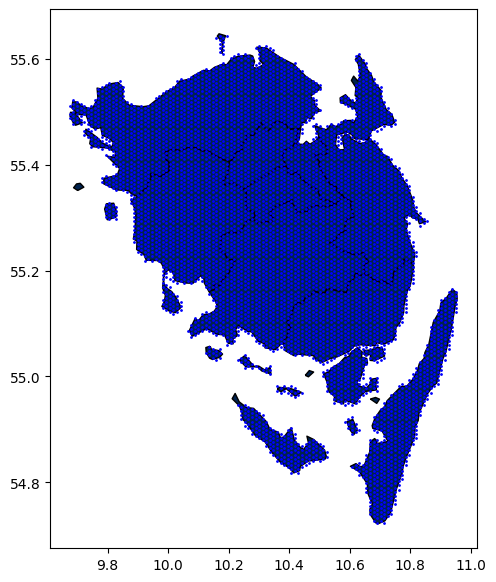

In [6]:
# Draw hexCenters on map (Possible way to visualize)

import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import Point, Polygon
crs='epsg:4326'

points = []
for coord in data:
    point = Point(coord[0], coord[1])
    points.append(point)

geometry=points

geodata=gpd.GeoDataFrame(data, crs=crs, geometry=geometry)

fyn_shapefile = gpd.read_file(r"fyn/fyn.shp")

fig, ax = plt.subplots(figsize=(7,7))
fyn_shapefile.plot(ax=ax, facecolor='Grey', edgecolor='k', alpha=1, linewidth=1, cmap='cividis')
geodata.plot(ax=ax, color='blue', markersize=1)


In [7]:
# Batch hexCenters to get them ready for Mapbox-calls

import requests
from dotenv import load_dotenv
import os

load_dotenv()

access_token = os.getenv("NEXT_PUBLIC_MB_ACCESS_TOKEN")


def batch_data(data, destination, batch_size):
    destination = destination
    batch_size = batch_size
    num_batches = (len(data) + batch_size - 1) // batch_size
    batches = []

    for chunk_idx in range(num_batches):
        start_idx = chunk_idx * batch_size
        end_idx = min((chunk_idx + 1) * batch_size, len(data))
        chunk = data[start_idx:end_idx]
        chunk.insert(0, destination)
        batches.append(chunk)

    return batches

batches = batch_data(data=data, destination=[10.369629, 55.383802], batch_size=24)




ModuleNotFoundError: No module named 'dotenv'

In [15]:
print(batches)

[[[10.369629, 55.383802], [9.893589118220314, 55.09411657188739], [9.893589118220314, 55.24988342811261], [9.893589118220314, 55.40565028433783], [9.893589118220314, 55.56141714056305], [10.129794559110158, 55.01623314377478], [10.129794559110158, 55.172], [10.129794559110158, 55.32776685622522], [10.129794559110158, 55.48353371245044], [10.366000000000001, 54.78258285943694], [10.366000000000001, 54.93834971566216], [10.366000000000001, 55.09411657188739], [10.366000000000001, 55.24988342811261], [10.366000000000001, 55.40565028433783], [10.366000000000001, 55.56141714056305], [10.602205440889843, 54.86046628754955], [10.602205440889843, 55.01623314377478], [10.602205440889843, 55.172], [10.602205440889843, 55.32776685622522], [10.602205440889843, 55.48353371245044], [10.838410881779687, 54.78258285943694], [10.838410881779687, 54.93834971566216], [10.838410881779687, 55.09411657188739], [10.838410881779687, 55.24988342811261], [10.838410881779687, 55.40565028433783]], [[10.369629, 55

In [24]:
# Make calls to mapbox api and collect them in matrix

distance_matrix = []

for index, batch in enumerate(batches):
    coordinates = ''
    for i, (lon, lat) in enumerate(batch):
        coordinates += f"{round(lon, 2)},{round(lat, 2)}"
        if i < len(batch) - 1:
            coordinates += ";"
            url = f"https://api.mapbox.com/directions-matrix/v1/mapbox/driving/{coordinates}?destinations=0&access_token={access_token}"
        else:
            url = f"https://api.mapbox.com/directions-matrix/v1/mapbox/driving/{coordinates}?destinations=0&access_token={access_token}"
    res = requests.get(url)
    distance_matrix.append(res.json())
    print(f"Distance {index} matrix appended")





Distance 0 matrix appended
Distance 1 matrix appended


In [25]:
# Save matrix in dict

distances = {
    "distance_matrix": distance_matrix
}

with open("distance_matrix_1.json", "w", encoding="utf-8") as f:
    f.write(str(distances))


In [26]:
# Convert matrix to csv

data = distance_matrix

data_list = []


for el in data:
    destinations = el["destinations"]
    durations = el["durations"]
    sources = el["sources"]
    for i in range(len(sources)):
        source = sources[i]
        duration = durations[i][0]

        data_dict = {
            "longitude": source["location"][0],
            "latitude": source["location"][1],
            "name": source["name"],
            "duration": duration,
            "hours": duration//3600,
            "minutes": (duration % 3600) // 60
        }

        data_list.append(data_dict)

df = pd.DataFrame(data_list)

df.to_csv("distances_and_durations_1.csv")